<a href="https://colab.research.google.com/github/MA-BOUSSOUALEF/Deep-Learning-with-Pytorch/blob/main/ML1_TP1_toy_NN_sujet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini MLP sur toy datasets

L'objectif de ce premier TP est de reproduire la page Web démo :

https://playground.tensorflow.org/

Plus précisément, il s'agit de manipuler un mini réseau de neurones, comprenant une seule couche cachée avec peu de neurones, sur des données jouet en 2-d.

Nous faisons ici de la classification binaire.

**Il y a du code à compléter, indiqué par ?? ou par des questions**


In [3]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Voici plusieurs jeux de données "jouet" ou "toy datasets".

On commence par blobs2. Puis à vous de tester avec les autres jeux.

In [4]:
n_samples = 400
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, centers=2, random_state=1)

centers = [[1, 1], [1, -1], [-1, -1], [-1, 1]]
blobs2 = datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std=0.25)


(-2.5, 2.5)

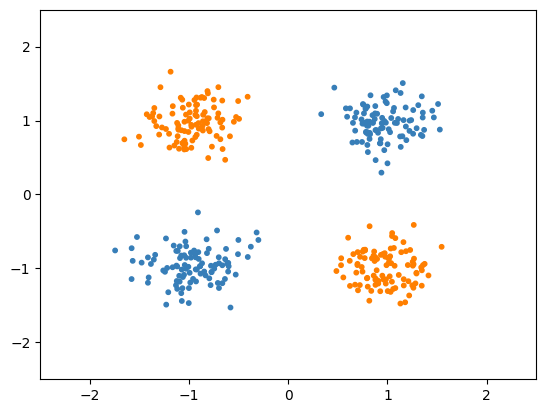

In [5]:
colors = np.array( ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf",] )

# changer ici le jeu de données : noisy+circles, noisy_moons, etc.
X, y = blobs2

# blobs2 a quatre classes par construction, et on en veut que deux
# Les autres jeux de données n'ont que deux classes donc
# si commentez ces deux lignes qd vous utilisez un jeu autre que blobs2
y[y==2]=0
y[y==3]=1

# on standardise les données (en général ça aide...)
X = StandardScaler().fit_transform(X)

# on plotte
plt.figure()

plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
# plt.xticks(())
# plt.yticks(())



In [6]:
# Ici on spitte les données en train et test.
# Dans la vraie vie, il faudrait même trois sous-ensembles, train/valid/test...

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Transformer les tableaux numpy en tenseurs torch float :
X_train = torch.tensor(X_train).to(torch.float)
X_test = torch.tensor(X_test).to(torch.float)

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

print(X_train.shape, X_test.shape)

torch.Size([268, 2]) torch.Size([132, 2])


In [7]:
X_train[:2], y_train[:2]

(tensor([[ 0.8780, -0.8476],
         [-0.4093,  1.3220]]),
 tensor([1, 1]))

L'architecture de notre premier réseau de neurones va être définie dans la prochaine cellule.

Nous allons mettre en oeuvre un mini réseau tel que representé dans cette figure, avec l'architecture suivante :

*   une seule couche cachée linéaire à 4 neurones,
*   suivie d'une fonction d'activation tanh,
*   puis d'une couche de sortie linéaire à deux neurones.

Nous n'ajoutons pas de fonction d'activation à la couche de sortie.

Vous remarquez que nous faisons une tâche de classification binaire (deux classes à distinguer) mais en utilisant deux neurones de sortie au lieu d'un seul qui suffirait. En pratique, ça peut être un peu plus facile à entraîner d'utiliser deux neurones, et donc on résoud le problème binaire par un modèle de classification "multi-classe" à deux classes. La fonction de loss sera à choisir en conséquence plus loin...

 <img src="https://www.irit.fr/~Thomas.Pellegrini/ens/M1ML1/mini_nn.png" alt="image nn"  width="400" height="320">

La déclaration des deux couches linéaires est à faire dans la méthode ```__init__()```. Consultez la documentation de Pytorch et du module ```torch.nn``` en particulier pour vous aider pour la déclaration de couches :

https://pytorch.org/docs/stable/nn.html

Pour les fonctions mathématiques comme ```tanh```, il y a plusieurs façons de faire, mais la plus simple à notre avis, est d'utiliser celles directement accessibles dans le module ```torch```, voir :

https://pytorch.org/docs/stable/torch.html#math-operations


Dans la fonction ```forward()```, vous appliquez les couches et la fonction d'activation dans l'ordre sur un mini-batch de features  ```x``` qui devient la variable ```out```.

Remarques :


1.   tous les modèles que vous allez définir dans les TP comportent ces deux méthodes, ```__init__()``` et ```forward()```.
2.   un modèle est déclaré sous forme d'une classe qui hérite de ```nn.Module```.
Cela permet d'appeler le modèle facilement sur des données par la suite, en écrivant : ```output = model(data)```
3.   À noter qu'il ne faut surtout pas écrire :
```output = model.forward(data)```
mais ```output = model(data)```

car une fonction ```__call__()``` est automatiquement appelée, qui fait
des allocations mémoire qui vont bien automatiquement pour nous. Cette méthode appelle ```forward()```.


In [8]:
#
class MLP(nn.Module):

    def __init__(self, num_hidden=4):
        super(MLP, self).__init__()
        self.layer1 = torch.nn.Linear(2,num_hidden) # nombre de feature en entreé (2 classe) et nombre de  coche caché =4
        self.layer2 = torch.nn.Linear(num_hidden,2) # couche de sortie avec nombre de classe caché et le nombre de classe de sortie
        self.activation = nn.Tanh() # Fonction d'activation tanh
        self.num_hidden = num_hidden

    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        return out

In [9]:
# On instancie le modèle et on regarde combien de paramètres il a
model = MLP()

def print_num_parameters(model):
    print("Nombre de paramètres :",
          sum(p.numel() for p in model.parameters()))

print_num_parameters(model)

# Ce nombre vous semble-t-il logique ? Vérifier sur le papier
# 8 poids et 4 bais
# 8 poids et 2 bais
# total 22

Nombre de paramètres : 22


La prochaine cellule réalise l'entraînement d'un modèle que l'on instancie à nouveau, pour être sûr de repartir sur un nouveau modèle à chaque fois que l'on exécute cette cellule.


epoch 1 --- acc = 99.24
epoch 11 --- acc = 100.00
epoch 21 --- acc = 100.00
epoch 25 --- acc = 100.00


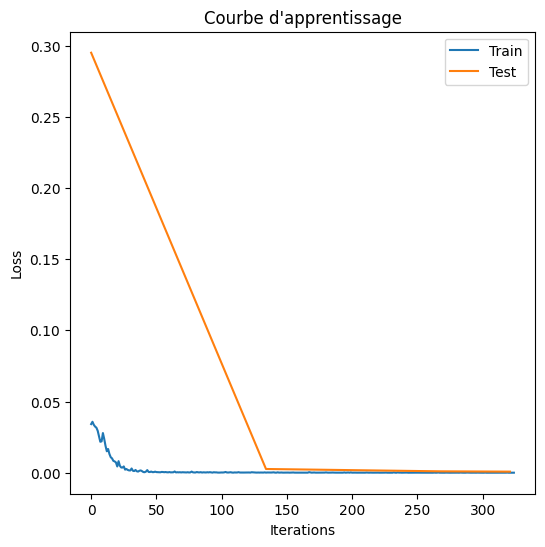

In [14]:
model = MLP()

learning_rate=0.1 # pour la onvergence du modéle

nb_epochs = 25 # combien le model va revoir les donneés pendant l'entrainement
bs = 20 # le nombre d'échantillons traiter avant la mise a  jour des paramétres

criterion = nn.CrossEntropyLoss() #fonction de perte

#optimizer = optim.SGD(model.parameters(),
                      # lr=learning_rate,
                      # momentum=0.9)

# Essayer Adam si vous le souhaitez :
optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

n = 0 # nombre d'iterations (pour faire des figures)
iters = []
losses = []
test_losses, test_acc = [], []
test_iters = []

for epoch in range(1, nb_epochs+1):

    # shuffle
    idx = torch.randperm(X_train.size(0))
    X_train_ = X_train[idx]
    y_train_ = y_train[idx]
    # print(len(X_train)//bs)

    model.train() # met le modèle en mode train

    for i in range(0, len(X_train)//bs):
        X_train_batch = X_train_[i*bs:(i+1)*bs]
        y_train_batch = y_train_[i*bs:(i+1)*bs]
        # print(X_train_batch.shape, y_train_batch.shape)

        out = model(X_train_batch)
        loss = criterion(out, y_train_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iters.append(n)
        losses.append(float(loss)/bs)
        n += 1

    if (epoch-1) % 10 == 0 or epoch==nb_epochs:
      model.eval() # met le modèle en mode eval
      # à quoi sert cette ligne ?
      with torch.no_grad():
        out = model(X_test)
        loss = criterion(out, y_test)
        test_losses.append(loss)

        pred = out.max(1, keepdim=True)[1] # retrouve l'indice de la log-proba maximale
        correct = pred.eq(y_test.view_as(pred)).sum().item()
        total = y_test.size(0)
        test_acc.append(correct/total*100.)
        test_iters.append((epoch-1)*len(X_train)//bs)
        print("epoch %d --- acc = %.2f"%(epoch, test_acc[-1]))

# print(iters)
# plotting
plt.figure(figsize=(6,6))
plt.title("Courbe d'apprentissage")
plt.plot(iters, losses, label="Train")
plt.plot(test_iters, test_losses, label="Test")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

## Graphique 2-d Heat map des prédictions du réseau

Écrire la fonction suivante ```fun()``` qui réalise une passe foward de ```data``` au travers du réseau ```model```donnés en arguments.

Cette fonction renvoie la prédiction de l'un des deux neurones de sortie de votre choix (choix arbitraire ici, on n'a pas défini quelle classe est la classe positive ou négative).

Veuillez normaliser les sorties des neurones par une ```softmax``` avant d'en sélectionner une seule.

L'output doit être converti en tableau ```numpy``` avant d' être retournée.

*   à quoi sert la ligne "with torch.no_grad():" ?

In [56]:
def fun(model, data):
    model.eval() # met le modèle en mode eval
    with torch.no_grad():
      out = model(data) # pour appeler forward
      out = torch.nn.functional.softmax(out)[0]
    return out.numpy()

Cette prochaine cellule trace la carte de chaleur (heat map) des prédictions du

*   Élément de liste
*   Élément de liste

réseau en deux dimensions

<ipython-input-56-f446ce4f69d1>:5: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



(2500,) [0.999383  0.9993723 0.9993554 ... 0.9997619 0.9997522 0.9997366]


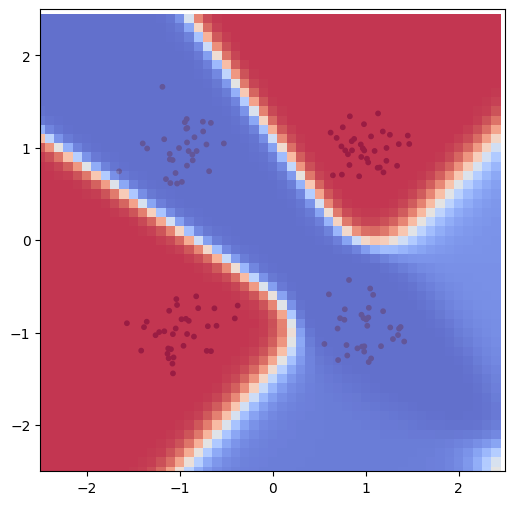

In [57]:

fig = plt.figure(figsize=(6,6))
plt.scatter(X_test[:, 0], X_test[:, 1], s=10, color=colors[y_test])

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

x1 = x2 = np.arange(-2.5, 2.5, 0.1)

# utiliser la fonction meshgrid de numpy :
X1, X2 = np.meshgrid(x1, x2)

output = np.array([fun(model, torch.from_numpy(np.array([x1, x2])).to(torch.float)) for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
print(output.shape, output)

output = output.reshape(X1.shape)

plt.pcolormesh(X1, X2, output, cmap=cm.coolwarm, alpha=0.8)

## Graphique 3-d interactif avec le module plotly

In [58]:
import plotly.graph_objects as go


fig = go.Figure(data=[go.Surface(x=X1, y=X2, z=output, opacity=0.7)])

# Les points de dataset :
fig.add_scatter3d(x=X_test[:, 0],
                  y=X_test[:, 1],
                  z=y_test,
                  marker=dict(
                      size=4,
                      color=colors[y_test],                # set color to an array/list of desired values
                      # colorscale='Viridis',   # choose a colorscale
                      opacity=0.8
    ),
                  mode = "markers") # Important pour ne pas avoir des lignes entre les différents points.

# On affiche la figure
fig.show()

## À faire




*   Ré-exécuter plusieurs fois l'entraînement du réseau et faire les graphiques. Que constatez-vous ?
*   Jouer avec le learning rate et l'optimiseur
*   Changer la fonction d'activation
*   Baisser ou augmenter le nb de neurones de la couche cachée
*   Refaire les expériences avec un autre jeu de données proposé

